<a href="https://colab.research.google.com/github/MattLeRoi/new_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank

Dataset information -
The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact with the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means 
client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None

In [2]:
# !pip install lightgbm
# !pip install catboost
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier, Pool, cv

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df=pd.read_csv('bank-full.csv', delimiter=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


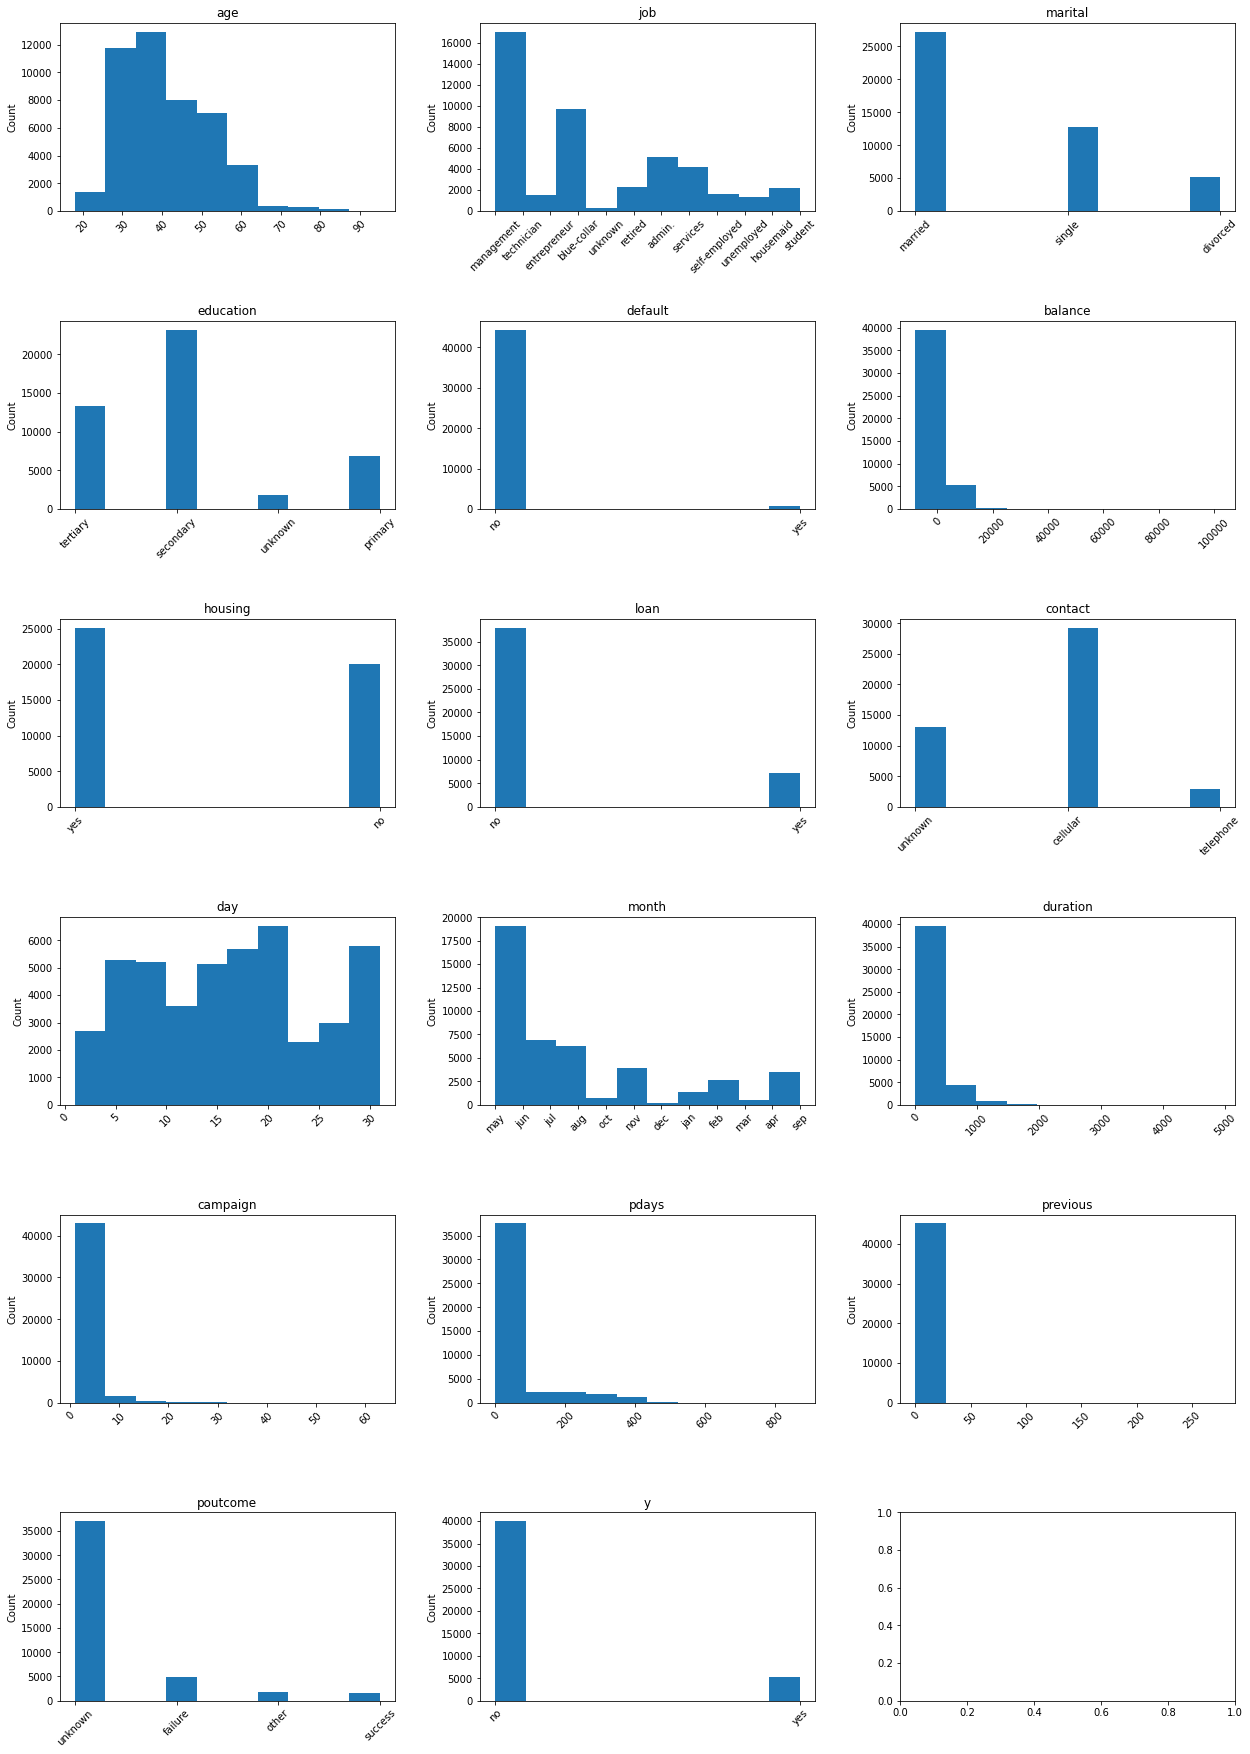

In [52]:
i=1
fig, axes = plt.subplots(6,3, figsize=(18,25))
for col in df.columns:
    plt.subplot(6,3,i)
    plt.title(col)
    plt.hist(df[col])
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.tight_layout(pad=3.0);
    i+=1

In [5]:
y_n_counts = df.y.value_counts()
print("Overall percent signed:",round(y_n_counts[1]/sum(y_n_counts)*100,2),'%')

Overall percent signed: 11.7 %


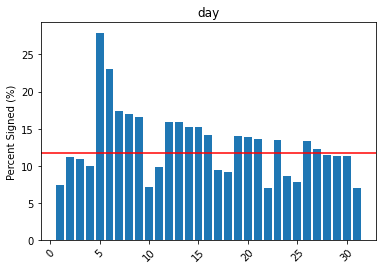

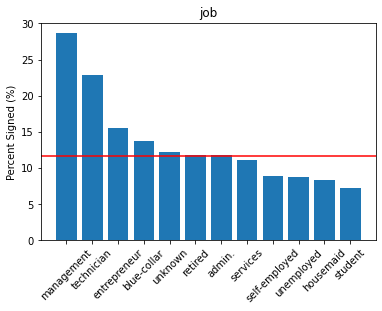

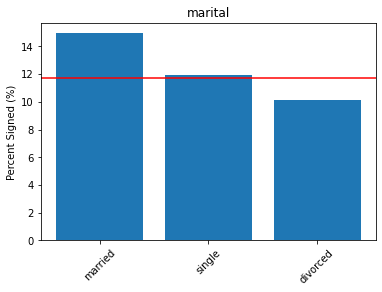

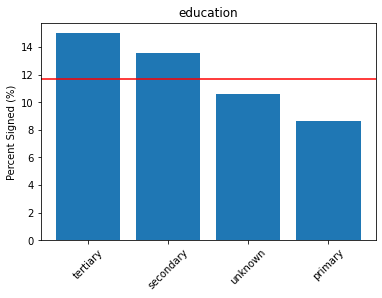

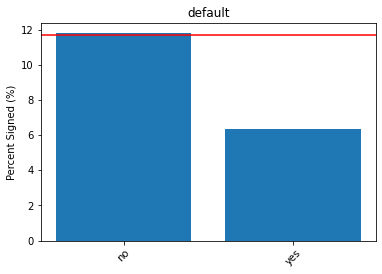

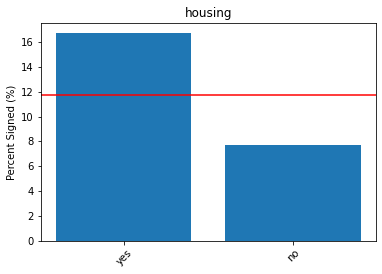

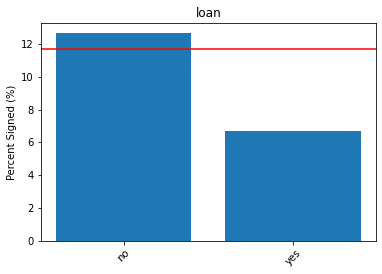

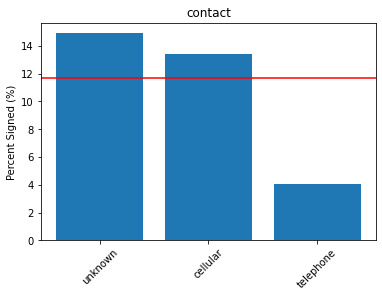

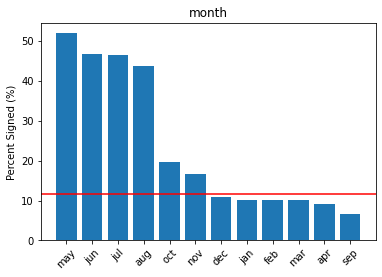

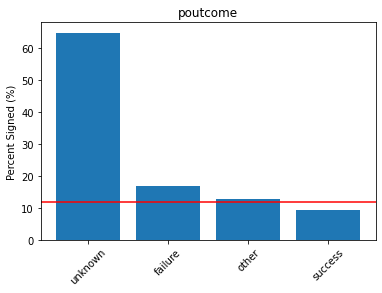

In [6]:
# create bar chart with category and % yes for each column
# needs to be binned for continuous

categorical_features = ['day','job','marital','education','default','housing','loan','contact','month','poutcome']
temp_y = []
# percentages = pd.DataFrame(columns = categorical_features)
for cat in categorical_features:
    temp_x = df[cat].unique()
#     for uniq in temp_x:
#         temp_y.append(
        
#         )
    temp_y = df.groupby(cat)['y'].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)
    plt.figure()
    plt.bar(temp_x, temp_y)
    plt.title(cat)
    plt.xticks(rotation=45)
    plt.ylabel('Percent Signed (%)')
    plt.axhline(y=11.7, color='r');

In [7]:
X=df.drop(['y','pdays'], axis=1) # The -1 in pdays throws off the math. previous also functions as a flag for previously contacted
y = [1 if target_y_n == "yes" else 0 for target_y_n in df['y']]

In [8]:
X_encoded = pd.get_dummies(X, columns=categorical_features)
X_encoded

,age,balance,duration,campaign,previous,day_1,day_2,day_3,day_4,day_5,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,44,29,151,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,33,2,76,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
3,47,1506,92,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
4,33,1,198,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,977,3,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
45207,71,1729,456,2,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
45208,72,5715,1127,5,3,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
45209,57,668,508,4,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [9]:
X_all_training,X_test_raw,y_all_training,y_test = train_test_split(X_encoded,y,random_state=42, test_size=.15) # 15% test set
X_train_raw,X_val_raw,y_train,y_val = train_test_split(X_all_training,y_all_training,random_state=42, test_size=.1/.85) # 10% validation set
X_val_raw

,age,balance,duration,campaign,previous,day_1,day_2,day_3,day_4,day_5,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
360,48,263,350,2,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
18751,43,5048,214,3,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
15173,34,1,54,3,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
20787,41,1545,183,2,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4517,33,163,135,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5239,31,360,395,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
37591,33,283,40,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
642,37,240,246,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1718,22,2412,238,2,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [10]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_encoded.columns)
X_val = pd.DataFrame(scaler.transform(X_val_raw), columns=X_encoded.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X_encoded.columns)

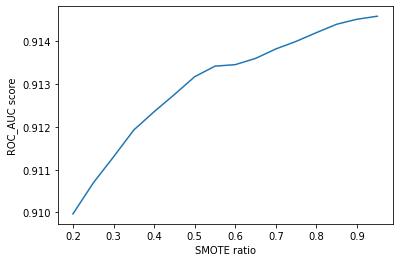

Wall time: 10.8 s


In [11]:
%%time
# This will loop through a range of ratios to feed into the SMOTE function to analyze the effect of oversampling the 
# churning customers to improve the sensitivity of the model. The results will be plotted to visualize the optimum value.

ratios = np.arange(.2,1,.05)
ROC_AUC_smote = []

for ratio in ratios:
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

    logreg_resample = LogisticRegression(fit_intercept=False, solver ='liblinear')
    logreg_resample.fit(X_train_resampled, y_train_resampled)
    y_proba = logreg_resample.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    ROC_AUC_smote.append(score)
    
fig, ax = plt.subplots()
ax.plot(ratios,ROC_AUC_smote,label='ROC_AUC score')
ax.set_ylabel('ROC_AUC score')
ax.set_xlabel('SMOTE ratio')
plt.show();

In [12]:
# Making the final smote version the one that runs through the rest of the code

X_train = X_train_resampled
y_train = y_train_resampled

w/o smoting:

Model	Score
0	LogisticRegression(random_state=42)	0.911404
1	(DecisionTreeClassifier(max_features='sqrt', r...	0.926134
2	XGBClassifier(base_score=None, booster=None, c...	0.931322
3	LGBMClassifier(random_state=42, verbose=0)	0.933431
4	<catboost.core.CatBoostClassifier object at 0x...	0.934607


In [13]:
roc_results = pd.DataFrame(columns=['Model','Score'])
imp_factors = pd.DataFrame(columns=['LogisticRegression','DecisionTreeClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier'])
def add_score (roc_results,model_name,model_title):
#     y_pred = model_name.predict(X_val)
    y_proba = model_name.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    print("ROC-AUC:", score)
    new_row_data = {'Model':model_title, 'Score':score}
    roc_results.loc[len(roc_results)] = new_row_data
    
#     for cat in ('balance','duration','age'):
#         plt.figure(figsize=(10,6))
#         plt.scatter(X_val_raw[cat],y_proba*100)
#         plt.xlabel(cat)
#         plt.ylabel('Probability of signing (%)')
    
    return roc_results

In [14]:
# Update with the ones i'm using 
log_reg = LogisticRegression(random_state=42)
rf=RandomForestClassifier(random_state=42)
xgb_model=XGBClassifier(random_state=42)
lgbm_model=LGBMClassifier(random_state=42,verbose=0)
cat_boost=CatBoostClassifier(random_state=42,verbose=0)


models = []
models.append(('log_reg', log_reg))
models.append(('rf', rf))
models.append(('xgb_model', xgb_model))
models.append(('lgbm_model', lgbm_model))
models.append(('cat_boost', cat_boost))

for title, model in models:
    model.fit(X_train,y_train)
    add_score(roc_results, model, title)

ROC-AUC: 0.9133975966008734
ROC-AUC: 0.922561879877123
ROC-AUC: 0.9305609500606147
ROC-AUC: 0.93087064369196
ROC-AUC: 0.9340158853461703


### Logistic Regression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

add_score(roc_results,log_reg);


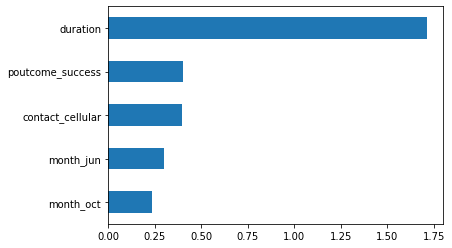

In [15]:
coefs = pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False).head(5).sort_values(ascending=True)
coefs.plot(kind='barh');
imp_factors['LogisticRegression']=coefs.sort_values(ascending=False).head(5).index

### Random Forest

rf = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=None,
    random_state=42)

rf.fit(X_train, y_train)


add_score(roc_results,rf)

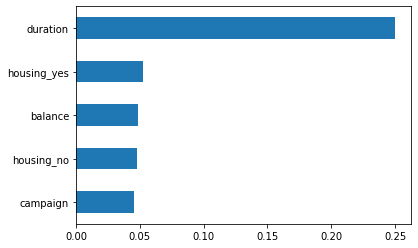

In [16]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(5).sort_values(ascending=True).plot(kind='barh');
imp_factors['RandomForestClassifier']=importances.sort_values(ascending=False).head(5).index

### XGBoost

xgb_model = XGBClassifier(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=4,
    random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

add_score(roc_results,xgb_model)

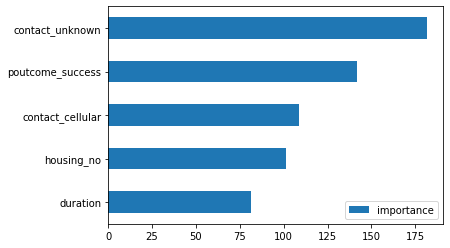

In [17]:
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'importance':list(importance.values())}, index=importance.keys())

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['XGBClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

### Light GBM

lgbm_model = LGBMClassifier(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=-1,
    random_state=42,
    verbose=0
)
lgbm_model.fit(X_train, y_train)

add_score(roc_results,lgbm_model)

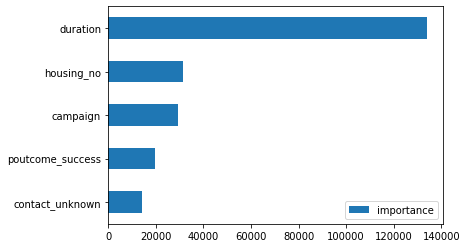

In [18]:
importance = lgbm_model.booster_.feature_importance(importance_type='gain')
feature_names = lgbm_model.feature_name_

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['LGBMClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

### Cat Boost

cat_boost = CatBoostClassifier(
#     iterations=200,
#     learning_rate=0.1,
#     depth=6,
    random_seed=42,
    verbose=0
)
cat_boost.fit(X_train, y_train)

add_score(roc_results,cat_boost)

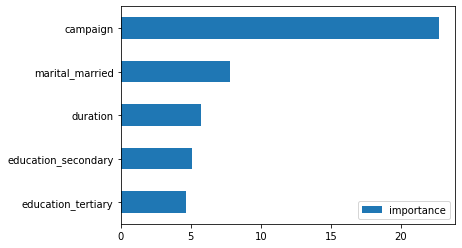

In [19]:
importance = cat_boost.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['CatBoostClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

In [20]:
imp_factors

,LogisticRegression,DecisionTreeClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier,RandomForestClassifier
0,duration,NaN,contact_unknown,duration,campaign,duration
1,poutcome_success,NaN,poutcome_success,housing_no,marital_married,housing_yes
2,contact_cellular,NaN,contact_cellular,campaign,duration,balance
3,month_jun,NaN,housing_no,poutcome_success,education_secondary,housing_no
4,month_oct,NaN,duration,contact_unknown,education_tertiary,campaign


In [21]:
factor_importance_results = pd.DataFrame(columns=['score'], index=X_train.columns)

for cat in X_train.columns:
    tot_factor_weight=0
    for col in imp_factors:
        ind_factor_weight = 5-imp_factors[imp_factors[col].str.contains(cat, case=False, na=False)].index
        if ind_factor_weight > 0:
            tot_factor_weight += ind_factor_weight
    if tot_factor_weight > 0:
        factor_importance_results.at[cat, 'score'] = tot_factor_weight[0]
    else: factor_importance_results.at[cat, 'score'] = 0

factor_importance_results.sort_values(by='score', ascending=False).head(5)

,score
duration,19
poutcome_success,10
campaign,9
housing_no,8
contact_cellular,6


In [22]:
all_encoded = X_encoded.copy()
all_encoded['y']=df['y']
for ind in factor_importance_results.sort_values(by='score', ascending=False).head(5).index:
    print(ind,(all_encoded[ind] == 1).sum())

duration 2
poutcome_success 1511
campaign 17544
housing_no 20081
contact_cellular 29285


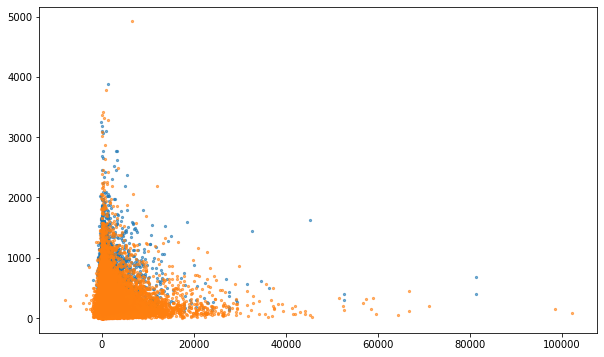

In [23]:
yes = all_encoded[all_encoded['y']=='yes']
no = all_encoded[all_encoded['y']!='yes']

plt.figure(figsize=(10,6))
plt.scatter(yes['balance'],yes['duration'], s=5, alpha=.6)
plt.scatter(no['balance'],no['duration'], s=5, alpha=.6);

## Grid search cv

In [24]:
%%time
cat_model = CatBoostClassifier( early_stopping_rounds=50, verbose=100, random_state=42)

param_grid = {
#     'depth': [6, 8, 10], # was 6, 8, 10
#     'learning_rate': [.03, 0.05, 0.07], # was .03, 0.05, 0.07
#     'l2_leaf_reg': [1, 3], # was 1,3
    'iterations': [300, 500]
}

grid = GridSearchCV(cat_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Learning rate set to 0.110451
0:	learn: 0.6021595	total: 14.9ms	remaining: 7.42s
100:	learn: 0.1367310	total: 1.39s	remaining: 5.48s
200:	learn: 0.1160342	total: 2.72s	remaining: 4.05s
300:	learn: 0.1045501	total: 4s	remaining: 2.64s
400:	learn: 0.0956812	total: 5.17s	remaining: 1.28s
499:	learn: 0.0889627	total: 6.43s	remaining: 0us
Best params: {'iterations': 500}
Wall time: 26.8 s


Best params: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.05}

Best params: {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.03}; ROC-AUC: 0.93278

In [25]:
gscv_model = grid.best_estimator_
add_score(roc_results,gscv_model,'grid_search_cv')

ROC-AUC: 0.9335352839863629


,Model,Score
0,log_reg,0.913398
1,rf,0.922562
2,xgb_model,0.930561
3,lgbm_model,0.930871
4,cat_boost,0.934016
5,grid_search_cv,0.933535


## Cat Boost built-in tuner

In [26]:
%%time
X_tuning = pd.concat([X_train,X_val], ignore_index=True)
y_tuning = y_train + y_val

train_pool = Pool(X_tuning, label=y_tuning)

params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': False,
    'iterations': 500,
}
        
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    plot=False
)

Training on fold [0/5]

bestTest = 0.9881197277
bestIteration = 499

Training on fold [1/5]

bestTest = 0.9878847576
bestIteration = 499

Training on fold [2/5]

bestTest = 0.988387754
bestIteration = 499

Training on fold [3/5]

bestTest = 0.9883774015
bestIteration = 499

Training on fold [4/5]

bestTest = 0.9875463622
bestIteration = 499

Wall time: 42.8 s


In [27]:
# Best iteration
best_iter = len(cv_results)
best_auc = cv_results['test-AUC-mean'].max()

print(f"Best iteration: {best_iter}")
print(f"Best CV AUC: {best_auc:.4f}")

Best iteration: 500
Best CV AUC: 0.9881


%%time

depths = [10] # was 6,8,10
learning_rates = [0.03] # was .03, .05, .07
l2_leaf_regs = [1] # was 1,3

results = []

for d in depths:
    for lr in learning_rates:
        for l2 in l2_leaf_regs:
            params.update({'depth': d, 'learning_rate': lr, 'l2_leaf_reg':l2})
            cv_data = cv(params=params, pool=train_pool, fold_count=3, shuffle=True, verbose=False) # fold_count was 5
            best_auc = cv_data['test-AUC-mean'].max()
            results.append((d, lr, l2, best_auc))

results_df = pd.DataFrame(results, columns=['depth', 'learning_rate', 'l2_leaf_reg', 'AUC'])
results_df=results_df.sort_values('AUC', ascending=False)
print(results_df)


In [37]:
%%time

from itertools import product

depths = [4,6,8] # was 6,8,10
learning_rates = [0.03, .05, .07] # was .03, .05, .07
l2_leaf_regs = [1,3] # was 1,3

train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

results = []

for lr, d, l2 in product(learning_rates, depths, l2_leaf_regs):
    model = CatBoostClassifier(
        learning_rate=lr,
        depth=d,
        l2_leaf_reg=l2,
        iterations=1000,
        early_stopping_rounds=50,
        use_best_model=True,
        verbose=False,
    )
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
    y_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    results.append((d, lr, l2, score))

results_df = pd.DataFrame(results, columns=['depth', 'learning_rate', 'l2_leaf_reg', 'AUC'])
results_df=results_df.sort_values('AUC', ascending=False)
print(results_df)
    
    
    
# results = []

# for d in depths:
#     for lr in learning_rates:
#         for l2 in l2_leaf_regs:
            
#             params.update({'depth': d, 'learning_rate': lr, 'l2_leaf_reg':l2})
#             cat_data = cv(params=params, pool=train_pool, fold_count=3, shuffle=True, verbose=False) # fold_count was 5
#             best_auc = cat_data['test-AUC-mean'].max()
#             results.append((d, lr, l2, best_auc))

# results_df = pd.DataFrame(results, columns=['depth', 'learning_rate', 'l2_leaf_reg', 'AUC'])
# results_df=results_df.sort_values('AUC', ascending=False)
# print(results_df)

    depth  learning_rate  l2_leaf_reg       AUC
5       8           0.03            3  0.935014
17      8           0.07            3  0.934943
4       8           0.03            1  0.934668
14      6           0.07            1  0.934444
15      6           0.07            3  0.934345
10      8           0.05            1  0.934086
8       6           0.05            1  0.934073
9       6           0.05            3  0.934032
11      8           0.05            3  0.933620
16      8           0.07            1  0.933347
13      4           0.07            3  0.933225
3       6           0.03            3  0.933121
12      4           0.07            1  0.933086
2       6           0.03            1  0.932772
6       4           0.05            1  0.932505
7       4           0.05            3  0.932286
0       4           0.03            1  0.931107
1       4           0.03            3  0.930455
Wall time: 3min 30s


In [29]:
# print(cat_data)

    depth  learning_rate  l2_leaf_reg       AUC
14     10           0.05            1  0.990655
12     10           0.03            1  0.990643
16     10           0.07            1  0.990462
13     10           0.03            3  0.990407
15     10           0.05            3  0.990402
17     10           0.07            3  0.990274
8       8           0.05            1  0.990181
11      8           0.07            3  0.990158
10      8           0.07            1  0.990132
9       8           0.05            3  0.990113
6       8           0.03            1  0.990105
5       7           0.07            3  0.990067
2       7           0.05            1  0.990014
3       7           0.05            3  0.989985
4       7           0.07            1  0.989971
7       8           0.03            3  0.989924
0       7           0.03            1  0.989684
1       7           0.03            3  0.989566
Wall time: 1h 10min 59s

In [30]:
results_df=results_df.sort_values('AUC', ascending=False)
display(results_df)

,depth,learning_rate,l2_leaf_reg,AUC
1,6,0.03,3,0.933121
0,6,0.03,1,0.932772


In [31]:
%%time
best_params = {
    'depth': 10,
    'learning_rate': 0.05,
    'iterations': 500,
    'l2_leaf_reg': 1,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
}

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, verbose=0);

Wall time: 1min 2s


In [32]:
add_score(roc_results,final_model,'final_model1')

ROC-AUC: 0.9313867997442025


,Model,Score
0,log_reg,0.913398
1,rf,0.922562
2,xgb_model,0.930561
3,lgbm_model,0.930871
4,cat_boost,0.934016
5,grid_search_cv,0.933535
6,final_model1,0.931387


In [33]:
%%time
best_params = {
    'depth': 8,
    'learning_rate': 0.05,
    'iterations': 500,
    'l2_leaf_reg': 1,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
}

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, verbose=0);

Wall time: 13 s


In [34]:
add_score(roc_results,final_model,'final_model2')

ROC-AUC: 0.9341149480754368


,Model,Score
0,log_reg,0.913398
1,rf,0.922562
2,xgb_model,0.930561
3,lgbm_model,0.930871
4,cat_boost,0.934016
5,grid_search_cv,0.933535
6,final_model1,0.931387
7,final_model2,0.934115


In [35]:
%%time
for model_name in [log_reg,rf,xgb_model,lgbm_model,cat_boost, final_model]:
    y_pred = model_name.predict(X_test)
    y_proba = model_name.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_proba)
    print(model_name," ROC-AUC:", score)

LogisticRegression(random_state=42)  ROC-AUC: 0.9088779282289939
RandomForestClassifier(random_state=42)  ROC-AUC: 0.9203081293165334
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)  ROC-AUC: 0.9283028442706142
LGBMClassifier(random_state=42, verbose=0)  ROC-AUC: 0.9284963404873301
<catboost.core.

In [36]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print('Accuracy:',round(accuracy_score(y_test,y_pred)*100,2),'%')
print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_proba))


Accuracy: 90.52 %
[[5701  269]
 [ 374  438]]
0.9324764215164494


look at two sets - previously contacted vs not? 
check number of each

fix SMOTE cell (remove dollars references, etc.)

make plot of % yes for each category

write function to run through a list of models rather than individually, if possible